In [0]:
from google.colab import drive
import os, cv2, re, random
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
def reset_graph(seed=42):    #funkcja sluzaca do resetowania struktury grafu modulu tensorflow
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [0]:
drive.mount('/content/drive/') #podpiecie mojego dysku google

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
! date && unzip -q /content/drive/'My Drive'/'Data'/all.zip -d /content/  && date  #rozpakowanie zbioru danych - zbior cat vs dogs z kaggla

Sun Dec 30 15:55:29 UTC 2018
Sun Dec 30 15:55:45 UTC 2018


In [0]:
! date && unzip -q /content/train.zip -d /content/  && date #rozpakowanie zbioru uczacego

Sun Dec 30 15:55:51 UTC 2018
Sun Dec 30 15:56:00 UTC 2018


In [0]:
! date && unzip -q /content/test.zip -d /content/  && date #rozpakowanie zbioru testowego

Sun Dec 30 15:56:05 UTC 2018
Sun Dec 30 15:56:09 UTC 2018


In [0]:
img_width=150
img_height=150


In [0]:
def label_img(img):
  word_label=img.split('.')[-3] #obrazy nazywaja sie np cat.01.jpg wiec biore tylko 'cat' lub 'dog'
  if word_label=='cat':
    return [1,0]
  if word_label=='dog':
    return [0,1]

In [0]:
Train_dir="/content/train"  #lokalizacja rozpakowanego zbioru uczacego
def create_train_data():
  X=[]
  y=[]
  for img in tqdm(os.listdir(Train_dir)): #tqdm sluzy do wygenerowania progress baru - wizualizowanie postepu
    label=label_img(img)
    path=os.path.join(Train_dir,img) #sciezka dla kazdego z zdjec
    img=cv2.imread(path,cv2.IMREAD_COLOR)   #odczyt w kolorze - 3 kanaly rgb
    img=cv2.resize(img,(img_width,img_height))
    X.append(img)
    y.append(label)
  return X,y

In [0]:
Test_dir="/content/test" #lokalizacja rozpakowanego zbioru testowego
def create_test_data():
    testing_data=[]
    for img in tqdm(os.listdir(Test_dir)):
        path = os.path.join(Test_dir,img)
        img_num = img.split('.')[0]  #zdjecia nazywaja sie np. 10.jpg
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (img_width,img_height))
        testing_data.append([np.array(img),img_num])
    shuffle(testing_data)
    return testing_data

In [0]:
X,y=create_train_data()

100%|██████████| 25000/25000 [00:59<00:00, 417.21it/s]


In [0]:
X=np.array(X)
y=np.array(y)

In [0]:
print(X.shape) # 25000-ilosc probek, 150x150 rozmiary obrazu, 3 - liczba kanalow (rgb)
print(y.shape)

(25000, 150, 150, 3)
(25000, 2)


In [0]:
print(y[0])  

[1 0]


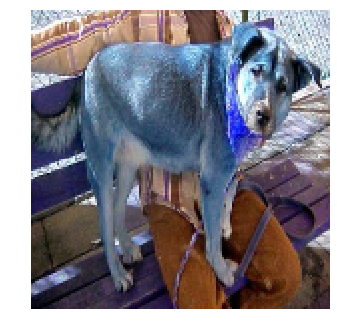

In [0]:
#przykladowy obraz z zbioru uczacego
some_img=X[5]
plt.imshow(some_img) 
plt.axis("off")
plt.show()

In [0]:
print(y[5]) # [0,1] oznacza psa [1,0] kota

[0 1]


In [0]:
rnd_idx = np.random.permutation(len(X))  #indeksy poszczegolnych zdjec z zbioru uczacego w losowej kolejnosci
print(len(rnd_idx))


25000


In [0]:
print(rnd_idx)

[19161 19432 12184 ... 23648 10762  3731]


In [0]:
shuffled_X,shuffled_y=X[rnd_idx],y[rnd_idx] #pomieszanie kolejnosci

In [0]:
print(len(shuffled_X))

25000


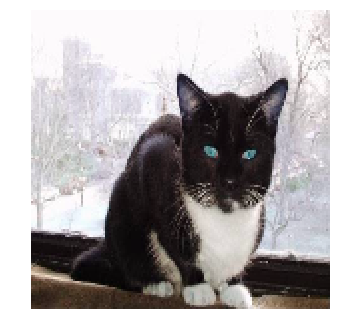

In [0]:
#przykladowy obraz z pomieszanego zbioru uczacego
some_img=shuffled_X[5]
plt.imshow(some_img) 
plt.axis("off")
plt.show()

In [0]:
print(shuffled_y[5])

[1 0]


In [0]:
print(shuffled_y[:20])

[[1 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [0 1]]


In [0]:
X_train,y_train=shuffled_X[:-200],shuffled_y[:-200]  #zbieramy tam wszystkie obrazy oprocz 200 ostatnich - zbior treningowy
X_val,y_val=shuffled_X[-200:],shuffled_y[-200:] #ostatnie 200 elementow zbioru - zbior walidacyjny

In [0]:
print(len(X_train))
print(len(y_train))
print(len(X_val))
print(len(y_val))

24800
24800
200
200


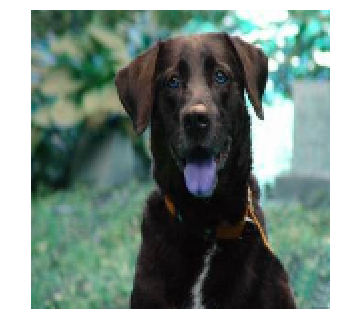

[0 1]


In [0]:
#przykladowy obraz z zbioru treningowego
some_img=X_train[233]
plt.imshow(some_img) 
plt.axis("off")
plt.show()
print(y_train[233])

In [0]:
print(y[:])

[[1 0]
 [1 0]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]


In [0]:

#pool_dropout_rate = 0.25
fc_dropout_rate=0.5

reset_graph() #zresetowanie grafu - w przypadku google colab jest to zbawienie (nie chcemy nadpisywac struktury grafu wiec lepiej przed kazdym utworzeniem resetowac)

with tf.name_scope("wejscia"):
    X = tf.placeholder(tf.float32, shape=[None,img_height,img_width ,3], name="X")
    y = tf.placeholder(tf.float32, shape=[None,2], name="y")
    training = tf.placeholder_with_default(False, shape=[], name='uczenie')
with tf.name_scope("splotowe"):
  conv1 = tf.layers.conv2d(X, filters=64, kernel_size=3,
                         strides=1, padding="SAME",
                         activation=tf.nn.relu, name="splot1")
  print(conv1.shape)
  pool1 = tf.layers.max_pooling2d(conv1, pool_size=[2, 2], strides=[2, 2], padding="VALID")
  print(pool1.shape)  
  conv2 = tf.layers.conv2d(pool1, filters=64, kernel_size=3,
                         strides=1, padding="SAME",
                        activation=tf.nn.relu, name="splot2")
  print(conv2.shape) 
  pool2= tf.layers.max_pooling2d(conv2, pool_size=[2, 2], strides=[2, 2], padding="VALID")
  print(pool2.shape)
  conv3 = tf.layers.conv2d(pool2, filters=64, kernel_size=3,
                         strides=1, padding="SAME",
                         activation=tf.nn.relu, name="splot3")
  pool3= tf.layers.max_pooling2d(conv3, pool_size=[2, 2], strides=[2, 2], padding="VALID")
  print(conv3.shape)
  print(pool3.shape)
  conv4 = tf.layers.conv2d(pool3, filters=64, kernel_size=3,
                         strides=1, padding="SAME",
                         activation=tf.nn.relu, name="splot4")
  print(conv4.shape)
  pool4= tf.layers.max_pooling2d(conv4, pool_size=[2, 2], strides=[2, 2], padding="VALID") 
  print(pool4.shape)
  
with tf.name_scope("pp"):
    flatten1=tf.layers.flatten(pool4)
    print(flatten1.shape)
    fc1 = tf.layers.dense(flatten1, 64, activation=tf.nn.relu, name="pp1")
    print(fc1.shape)
    fc1_drop = tf.layers.dropout(fc1, fc_dropout_rate, training=training)
    print(fc1_drop.shape)
with tf.name_scope("wyjscie"):
    logits = tf.layers.dense(fc1_drop, 2,name="wyjscie")
    print(logits.shape)
    Y_proba = tf.nn.softmax(logits, name="Y_prawd")

with tf.name_scope("uczenie"):
    xentropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("ocena"):
    correct_pred = tf.equal(tf.argmax(logits,1),tf.argmax( y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

with tf.name_scope("inicjacja_i_zapisywanie"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    


(?, 150, 150, 64)
(?, 75, 75, 64)
(?, 75, 75, 64)
(?, 37, 37, 64)
(?, 37, 37, 64)
(?, 18, 18, 64)
(?, 18, 18, 64)
(?, 9, 9, 64)
(?, 5184)
(?, 64)
(?, 64)
(?, 2)


In [0]:
def get_model_params():
    gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
    return {gvar.op.name: value for gvar, value in zip(gvars, tf.get_default_session().run(gvars))}

def restore_model_params(model_params):
    gvar_names = list(model_params.keys())
    assign_ops = {gvar_name: tf.get_default_graph().get_operation_by_name(gvar_name + "/Assign")
                  for gvar_name in gvar_names}
    init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
    feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
    tf.get_default_session().run(assign_ops, feed_dict=feed_dict)

In [0]:
n_epochs = 1000
batch_size = 50

best_loss_val = np.infty
check_interval = 100
checks_since_last_progress = 0
max_checks_without_progress = 20
best_model_params = None 

iteration=0

with tf.Session() as sess:
    init.run()
    print("Start...")
    for epoch in range(n_epochs):
      rnd_idx = np.random.permutation(len(X_train))     
      for rnd_indices in np.array_split(rnd_idx, int(len(X_train) // batch_size)):
        iteration+=1
        X_batch, y_batch =X_train[rnd_indices],y_train[rnd_indices] 
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch, training: True})
        if iteration % check_interval == 0:          
          loss_val = loss.eval(feed_dict={X: X_val,y: y_val})
          print("Iteracja: ",iteration,", loss val checking: ",loss_val, "best loss val: ",best_loss_val)
          if loss_val < best_loss_val:
            best_loss_val = loss_val
            checks_since_last_progress = 0
            best_model_params = get_model_params()
          else:
            checks_since_last_progress += 1
      acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
      acc_val = accuracy.eval(feed_dict={X: X_val,
                                           y: y_val})
      print("Epoka {}, dokładność dla zbioru treningowego {:.4f}%, walidacyjnego: {:.4f}%, najlepsza wartosc straty dla zbioru walidacyjnego: {:.6f}".format(
                  epoch, acc_train * 100, acc_val * 100, best_loss_val))
      if checks_since_last_progress > max_checks_without_progress:
        print("Wczesne zatrzymywanie!")
        break
    
    if best_model_params:
      restore_model_params(best_model_params)
      acc_test = accuracy.eval(feed_dict={X:X_val,
                                        y: y_val})
    print("Ostateczna dokładność dla zbioru walidacyjnego:", acc_test)
    print("ilosc iteracji: ",iteration)
    save_path = saver.save(sess, "./mojModelProjekt")

Start...
Iteracja:  100 , loss val checking:  0.69118685 best loss val:  inf
Iteracja:  200 , loss val checking:  0.6771486 best loss val:  0.69118685
Iteracja:  300 , loss val checking:  0.69381124 best loss val:  0.6771486
Iteracja:  400 , loss val checking:  0.6939872 best loss val:  0.6771486
Epoka 0, dokładność dla zbioru treningowego 42.0000%, walidacyjnego: 48.5000%, najlepsza wartosc straty dla zbioru walidacyjnego: 0.677149
Iteracja:  500 , loss val checking:  0.6933945 best loss val:  0.6771486
Iteracja:  600 , loss val checking:  0.678254 best loss val:  0.6771486
Iteracja:  700 , loss val checking:  0.6131549 best loss val:  0.6771486
Iteracja:  800 , loss val checking:  0.68059355 best loss val:  0.6131549
Iteracja:  900 , loss val checking:  0.6372982 best loss val:  0.6131549
Epoka 1, dokładność dla zbioru treningowego 62.0000%, walidacyjnego: 49.0000%, najlepsza wartosc straty dla zbioru walidacyjnego: 0.613155
Iteracja:  1000 , loss val checking:  0.6941147 best loss v

In [0]:
reset_graph() #zresetowanie grafu

with tf.name_scope("wejscia"):
    X = tf.placeholder(tf.float32, shape=[None,img_height,img_width ,3], name="X")
    y = tf.placeholder(tf.float32, shape=[None,2], name="y")
    training = tf.placeholder_with_default(False, shape=[], name='uczenie')
with tf.name_scope("splotowe"):
  conv1 = tf.layers.conv2d(X, filters=64, kernel_size=3,
                         strides=1, padding="SAME",
                         activation=tf.nn.relu, name="splot1")
  print(conv1.shape)
  pool1 = tf.layers.max_pooling2d(conv1, pool_size=[2, 2], strides=[2, 2], padding="VALID")
  print(pool1.shape)  
  conv2 = tf.layers.conv2d(pool1, filters=64, kernel_size=3,
                         strides=1, padding="SAME",
                        activation=tf.nn.relu, name="splot2")
  print(conv2.shape) 
  pool2= tf.layers.max_pooling2d(conv2, pool_size=[2, 2], strides=[2, 2], padding="VALID")
  print(pool2.shape)
  conv3 = tf.layers.conv2d(pool2, filters=64, kernel_size=3,
                         strides=1, padding="SAME",
                         activation=tf.nn.relu, name="splot3")
  pool3= tf.layers.max_pooling2d(conv3, pool_size=[2, 2], strides=[2, 2], padding="VALID")
  print(conv3.shape)
  print(pool3.shape)
  conv4 = tf.layers.conv2d(pool3, filters=64, kernel_size=3,
                         strides=1, padding="SAME",
                         activation=tf.nn.relu, name="splot4")
  print(conv4.shape)
  pool4= tf.layers.max_pooling2d(conv4, pool_size=[2, 2], strides=[2, 2], padding="VALID") 
  print(pool4.shape)
  
with tf.name_scope("pp"):
    flatten1=tf.layers.flatten(pool4)
    print(flatten1.shape)
    fc1 = tf.layers.dense(flatten1, 64, activation=tf.nn.relu, name="pp1")
    print(fc1.shape)
    fc1_drop = tf.layers.dropout(fc1, fc_dropout_rate, training=training)
    print(fc1_drop.shape)
with tf.name_scope("wyjscie"):
    logits = tf.layers.dense(fc1_drop, 2,name="wyjscie")
    print(logits.shape)
    Y_proba = tf.nn.softmax(logits, name="Y_prawd")

with tf.name_scope("uczenie"):
    xentropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("ocena"):
    correct_pred = tf.equal(tf.argmax(logits,1),tf.argmax( y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
saver=tf.train.Saver()    
prep_img=X_val[46].reshape(-1,img_height,img_width,3)
with tf.Session() as sess:
  saver.restore(sess,"./mojModelProjekt") #Wczytanie wytrenowanego modelu
  prediction=sess.run([Y_proba],feed_dict={X:prep_img})
  print(prediction)
  print(prediction[0][0])
  if prediction[0][0][0]> prediction[0][0][1]:
    print("CAT")
  else:
    print("DOG")

(?, 150, 150, 64)
(?, 75, 75, 64)
(?, 75, 75, 64)
(?, 37, 37, 64)
(?, 37, 37, 64)
(?, 18, 18, 64)
(?, 18, 18, 64)
(?, 9, 9, 64)
(?, 5184)
(?, 64)
(?, 64)
(?, 2)
INFO:tensorflow:Restoring parameters from ./mojModelProjekt
[array([[2.8035743e-06, 9.9999714e-01]], dtype=float32)]
[2.8035743e-06 9.9999714e-01]
DOG


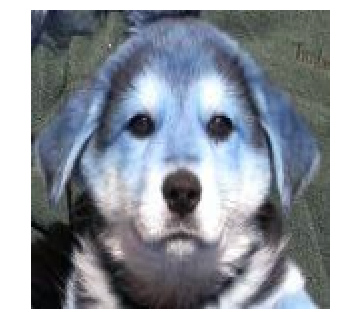

In [0]:
some_img=X_val[46]
plt.imshow(some_img) 
plt.axis("off")
plt.show()